# Clustering via Gausian Mixtures

In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


file_path_ISOMap_raw = "../../reduced_data/joueurs_ligue1_ISOMap_raw.csv"
file_path_ISOMap_per90 = "../../reduced_data/joueurs_ligue1_ISOMap_per90.csv"

data_ISOMap_raw = pd.read_csv(file_path_ISOMap_raw, encoding="utf-8")
data_ISOMap_per90 = pd.read_csv(file_path_ISOMap_per90, encoding="utf-8")
print(data_ISOMap_raw.head(1))

    isomap_1  isomap_2  isomap_3  isomap_4  isomap_5  isomap_6  isomap_7  \
0  21.062129 -4.222008 -2.173427 -3.796018 -2.686983  4.300071   2.18389   

     player_name  equipe positions  
0  Jordan Lefort  Angers        DF  


## Data Preparation : standardisation + columns removal

In [15]:
X_iso_raw = data_ISOMap_raw.drop(columns=['player_name', 'equipe', 'positions']).copy()
X_iso_per90 = data_ISOMap_per90.drop(columns=['player_name', 'equipe', 'positions']).copy()

scaler = StandardScaler()
X_iso_raw = scaler.fit_transform(X_iso_raw) 
X_iso_per90 = scaler.fit_transform(X_iso_per90)
print(X_iso_raw[1])

[ 1.34474033  1.30283802 -2.32940855  1.67514762  2.58475243  0.03916205
  0.59423857]


## GridSearch Analysis

In [45]:
def gmm_gridsearch(X, n_components_range=range(2, 8), cov_types=['full','tied','diag','spherical'], random_state=42, verbose=True):
    results = []

    for n in n_components_range:
        for cov in cov_types:
            gmm = GaussianMixture(n_components=n, covariance_type=cov, random_state=random_state)
            gmm.fit(X)
            labels = gmm.predict(X)
            
            log_likelihood = gmm.score(X)
            bic = gmm.bic(X)
            aic = gmm.aic(X)
            resposabilites = gmm.predict_proba(X)
            convergence = gmm.converged_
            try:
                sil_score = silhouette_score(X, labels)
                db_score = davies_bouldin_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)
            except Exception as e:
                sil_score = np.nan
                db_score = np.nan
                ch_score = np.nan
                
            results.append({
                'n_components': n,
                'covariance_type': cov,
                'BIC': bic,
                'AIC': aic,
                'log_likelihood': log_likelihood,
                'silhouette_score': sil_score,
                'davies_bouldin': db_score,
                'calinski_harabasz': ch_score,
                'converged': gmm.converged_
            })
            
    results_df = pd.DataFrame(results)
    results_df = results_df.T
    print(results_df)

    return results_df

gmm_results_raw = gmm_gridsearch(X_iso_raw, n_components_range=range(6,11), cov_types=['full','tied','diag','spherical'], random_state=42)

                            0            1            2            3   \
n_components                 6            6            6            6   
covariance_type           full         tied         diag    spherical   
BIC                 6252.61859  6410.660122  5950.721598  5910.997817   
AIC                5433.867955  6125.049435  5611.796917  5709.166265   
log_likelihood       -7.513315    -8.971546    -8.158854    -8.413163   
silhouette_score       0.14732     0.253127     0.158831     0.133366   
davies_bouldin        1.840462      1.39952     2.140499     2.212723   
calinski_harabasz     38.74962    48.213644    35.020581    29.480566   
converged                 True         True         True         True   

                            4            5            6            7   \
n_components                 7            7            7            7   
covariance_type           full         tied         diag    spherical   
BIC                6215.757667  6325.757359  5998.

## Run Gaussian mixtures

In [46]:
def run_gmm(X, data, n_clusters, random_state=42, covariance_type='full'):
    gmm = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, random_state=random_state)
    gmm.fit(X)
    labels = gmm.predict(X)

    df = pd.DataFrame(X, columns=[f'isomap_{i+1}' for i in range(X.shape[1])])
    df["cluster"] = labels

    meta_cols = ['player_name', 'equipe', 'positions']
    df_meta = data[meta_cols].copy()
    df_meta.index = df.index 
    df = df_meta.join(df)
    
    return df, gmm

X_gmm_iso_raw, gmm_iso_raw = run_gmm(X_iso_raw, data_ISOMap_raw, n_clusters = 10, covariance_type = "full", random_state = 42)
X_gmm_iso_per90, gmm_iso_per90 = run_gmm(X_iso_raw, data_ISOMap_raw, n_clusters = 10, covariance_type = "full", random_state = 42)

## Results Display

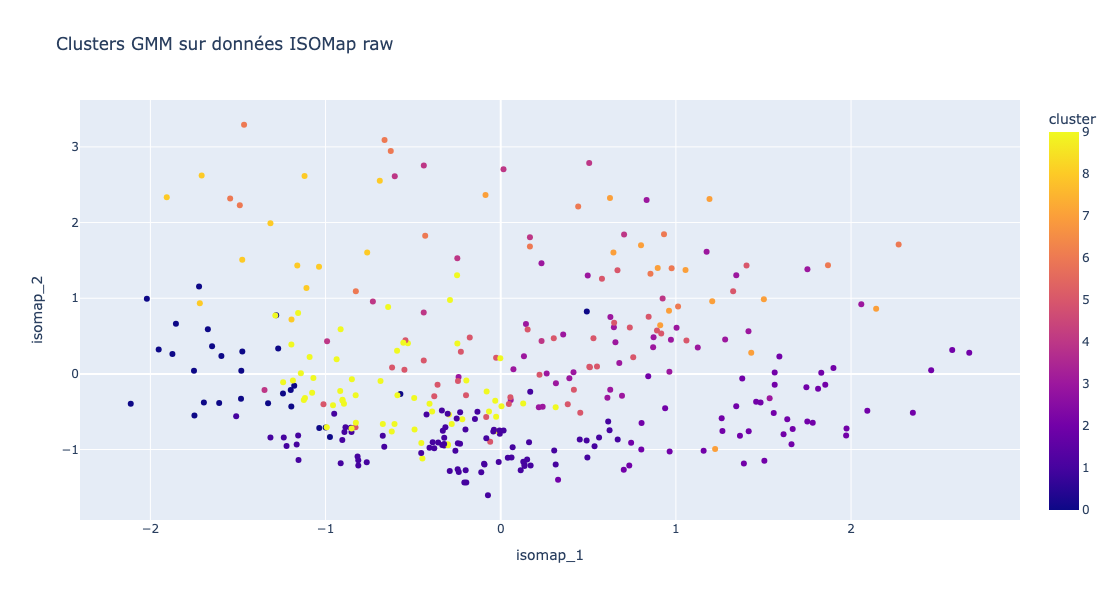

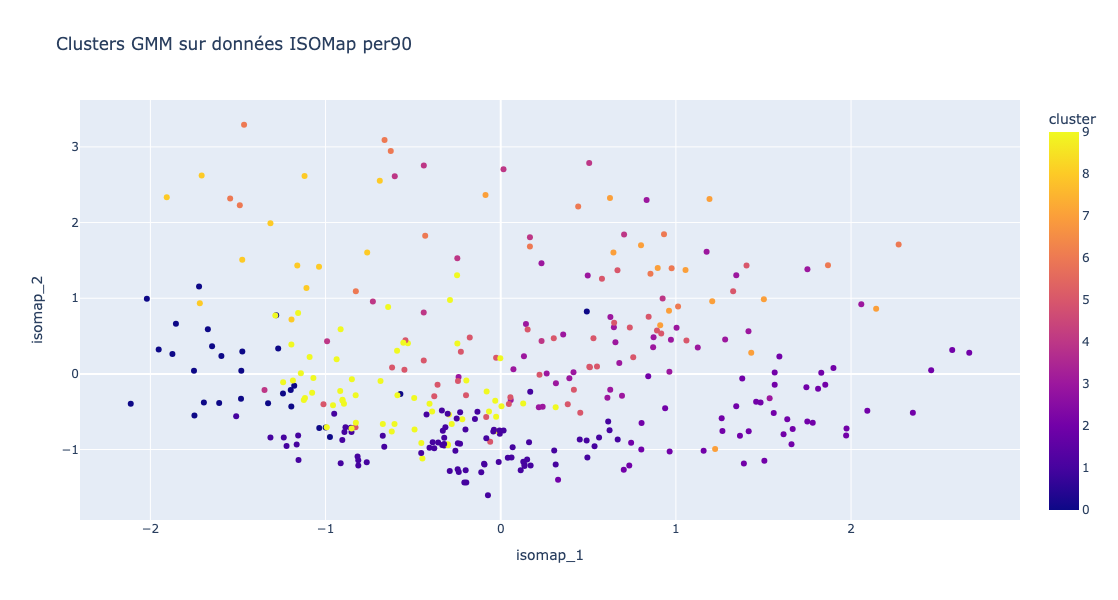

In [47]:
def print_results(X, column1, column2, data_name) :
    fig = px.scatter(
        X, 
        x= column1, 
        y= column2, 
        color='cluster', 
        hover_data=['player_name', 'positions'],  # ce qui s'affiche au survol
        title=f"Clusters GMM sur données {data_name}",
        width=800, 
        height=600,
        color_discrete_sequence= None
    )
    fig.show()

print_results(X_gmm_iso_raw, "isomap_1", "isomap_2", "ISOMap raw")
print_results(X_gmm_iso_per90, "isomap_1", "isomap_2", "ISOMap per90")